In [1]:
import pandas as pd
from gurobipy import *

### Aufgabe 1
a) Download und Visualisierung der Daten (01.01.2019 - 31.12.2019)

In [2]:
import os
os.getcwd()

'/Users/franziskawollscheid/Documents/University/WS22:23/SGA/SmartGridApplications-main 2'

In [3]:
df = pd.read_excel("Großhandelspreise_2019.xlsx")
pv = pd.read_csv("PV_2019.csv")
wind = pd.read_csv("wind_2019.csv")

df.head(3)

,Datum,Uhrzeit,Deutschland/Luxemburg[€/MWh],∅ Anrainer DE/LU[€/MWh],Belgien[€/MWh],Dänemark 1[€/MWh],Dänemark 2[€/MWh],Frankreich[€/MWh],Niederlande[€/MWh],Norwegen 2[€/MWh],Österreich[€/MWh],Polen[€/MWh],Schweden 4[€/MWh],Schweiz[€/MWh],Tschechien[€/MWh],DE/AT/LU[€/MWh],Italien (Nord)[€/MWh],Slowenien[€/MWh],Ungarn[€/MWh]
0,01.01.2019,00:00,28.32,-,69.49,28.32,28.32,51.00,68.92,48.77,33.48,-,28.32,50.26,8.5,-,51.00,51.00,59.9
1,01.01.2019,01:00,10.07,-,66.58,10.07,10.07,46.27,64.98,49.25,39.76,-,10.07,48.74,3.97,-,46.27,46.27,52.71
2,01.01.2019,02:00,-4.08,-,65.07,-4.08,-4.08,39.78,60.27,49.17,39.78,-,10.03,47.24,4.7,-,39.78,39.78,36.49


In [4]:
#benötigte Daten in df auswählen
df = df[['Datum', 'Uhrzeit', 'Deutschland/Luxemburg[€/MWh]']]
df = df.rename(columns={"Deutschland/Luxemburg[€/MWh]": "Kosten"})
df.head(3)

,Datum,Uhrzeit,Kosten
0,01.01.2019,00:00,28.32
1,01.01.2019,01:00,10.07
2,01.01.2019,02:00,-4.08


In [5]:
#aus Datum und Uhrzeit -> timestamp erstellen
df['time'] = df.apply(lambda row: row["Datum"] + " " + row["Uhrzeit"], axis = 1) 
df['time'] = pd.to_datetime(df['time'], format ="%d.%m.%Y %H:%M")
df.head(3)

,Datum,Uhrzeit,Kosten,time
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00


In [6]:
wind.head(3)

,time,local_time,electricity
0,2019-01-01 00:00,2019-01-01 01:00,1.038
1,2019-01-01 01:00,2019-01-01 02:00,1.184
2,2019-01-01 02:00,2019-01-01 03:00,1.402


In [7]:
#Problem: electricity von local_time 2019-01-01 00:00 ist nicht gegeben
#Lösung: einfach electricity von 1 für wind und 0 für PV angenommen
first_row = pd.DataFrame({'local_time': [wind.time[0]],
                   'electricity': [1]})
first_row

,local_time,electricity
0,2019-01-01 00:00,1


In [8]:
wind = first_row.append(wind)
wind.head(3)

/var/folders/pw/tqv76mmj6_j7x3xb8ym5rh080000gn/T/ipykernel_64475/954844438.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wind = first_row.append(wind)


,local_time,electricity,time
0,2019-01-01 00:00,1.000,NaN
0,2019-01-01 01:00,1.038,2019-01-01 00:00
1,2019-01-01 02:00,1.184,2019-01-01 01:00


In [9]:
#same for pv
first_row_pv = pd.DataFrame({'local_time': [pv.time[0]],'electricity': [0]})
pv = first_row_pv.append(pv)
pv

/var/folders/pw/tqv76mmj6_j7x3xb8ym5rh080000gn/T/ipykernel_64475/23313607.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pv = first_row_pv.append(pv)


,local_time,electricity,time
0,2019-01-01 00:00,0.0,NaN
0,2019-01-01 01:00,0.0,2019-01-01 00:00
1,2019-01-01 02:00,0.0,2019-01-01 01:00
2,2019-01-01 03:00,0.0,2019-01-01 02:00
3,2019-01-01 04:00,0.0,2019-01-01 03:00
...,...,...,...
8755,2019-12-31 20:00,0.0,2019-12-31 19:00
8756,2019-12-31 21:00,0.0,2019-12-31 20:00
8757,2019-12-31 22:00,0.0,2019-12-31 21:00
8758,2019-12-31 23:00,0.0,2019-12-31 22:00


In [10]:
#remove last row wind and pv
wind = wind[:-1]
print('wind shape:',wind.shape)
print('pv shape vorher:', pv.shape)
pv = pv[:-1]
print('pv shape nachher:', pv.shape)

wind = wind.reset_index()
pv = pv.reset_index()

print(df.shape)

wind shape: (8760, 3)
pv shape vorher: (8761, 3)
pv shape nachher: (8760, 3)
(8760, 4)


In [11]:
df['wind'] = wind.electricity
df['pv'] = pv.electricity
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0


In [12]:
df_show = df[0:1440] #erste zwei Monate (Januar + Februar)

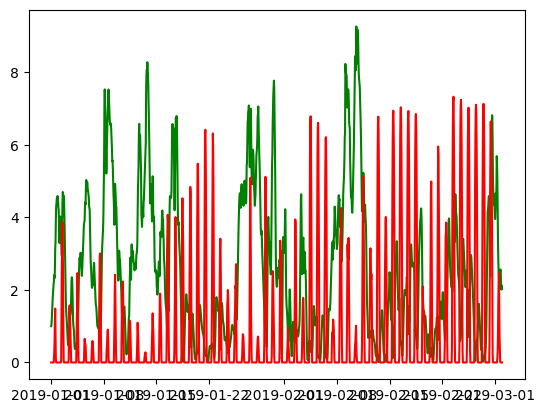

In [13]:
#plt.plot(df_show.time, df_show["Kosten"], label='kosten', color='b')
import matplotlib.pyplot as plt
plt.plot(df_show.time, df_show["wind"], color='g')
plt.plot(df_show.time, df_show["pv"], color='r')

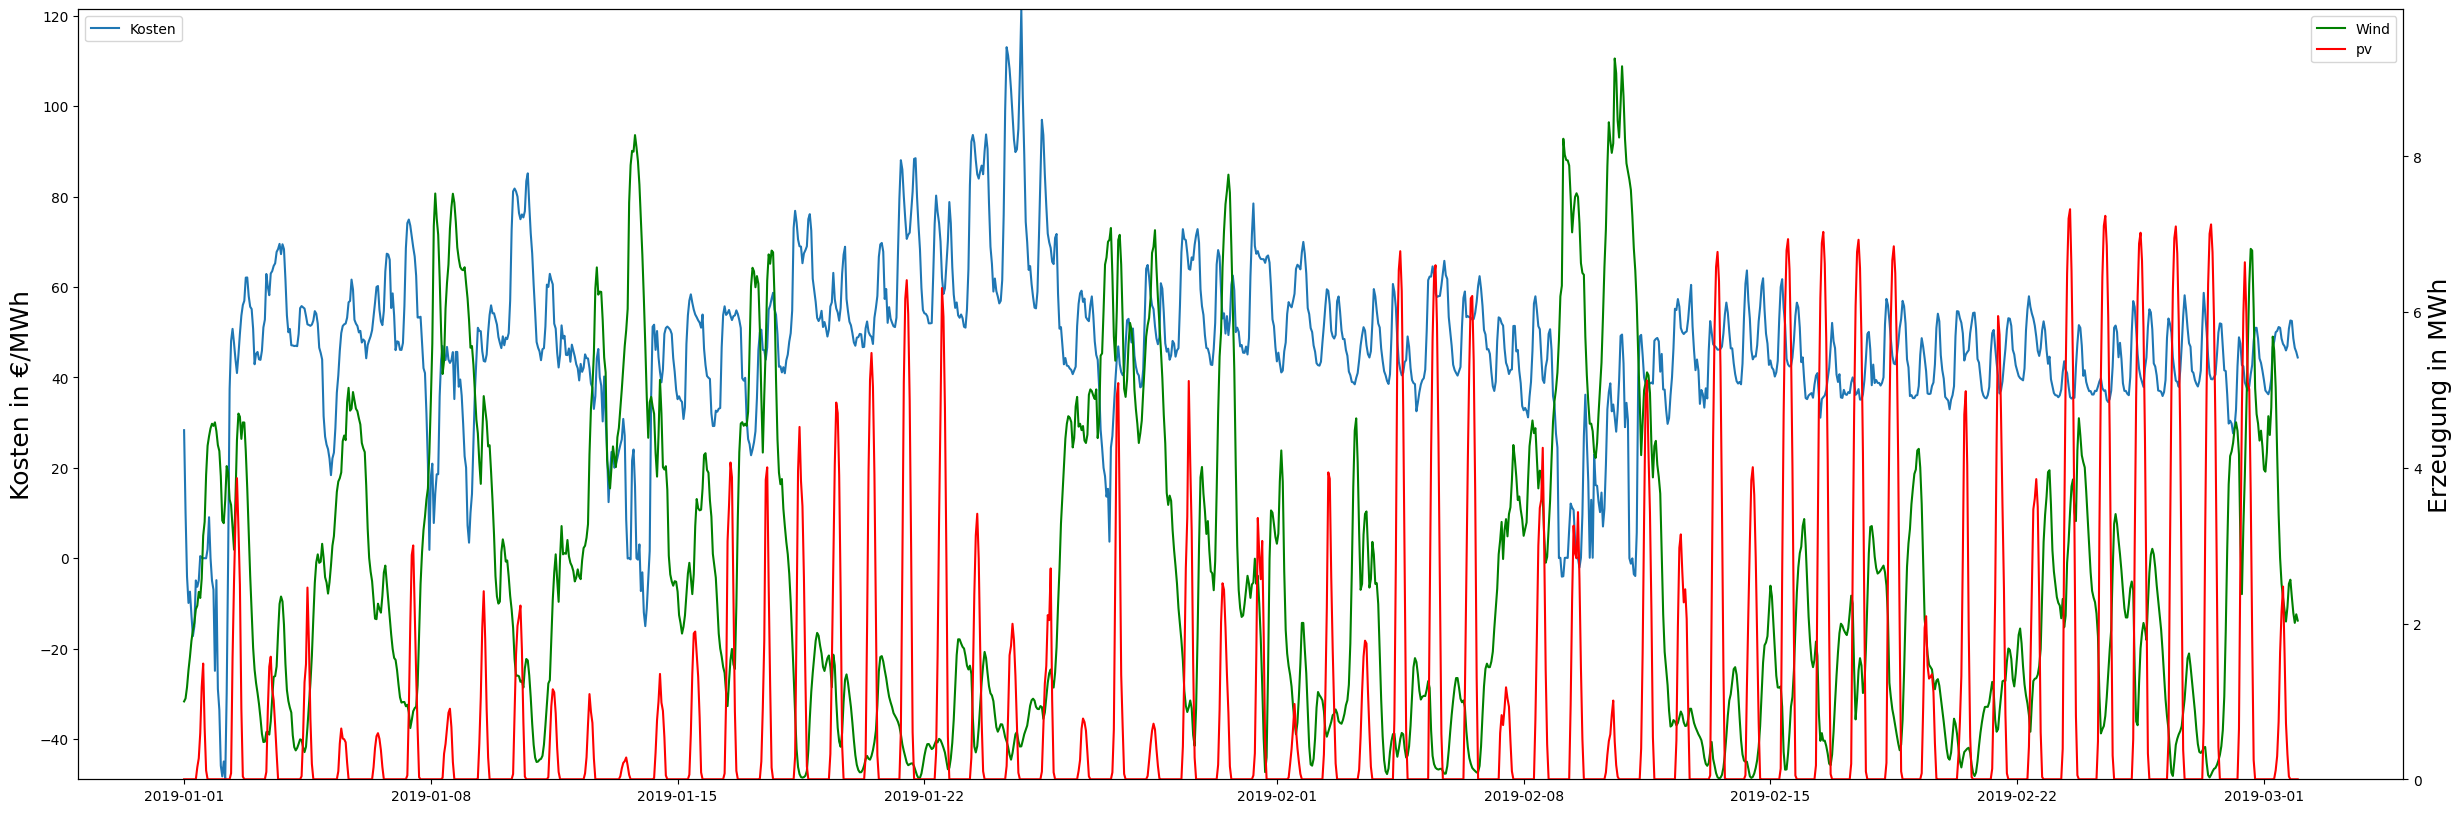

In [14]:
fig, ax1 = plt.subplots(figsize=(30,10))
ax2 = ax1.twinx()

ax1.plot(df_show["time"], df_show["Kosten"], label='Kosten')
ax2.plot(df_show["time"], df_show["wind"], color="g", label='Wind')
ax2.plot(df_show["time"], df_show["pv"], color="r", label='pv')
ax1.set_ylabel("Kosten in €/MWh", fontsize=18)
ax1.set_ylim([df_show.Kosten.min(),df.Kosten.max()])

ax2.set_ylabel("Erzeugung in MWh", fontsize=18)
ax2.set_ylim([0,df.wind.max()])

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

In [15]:
df_halbes_jahr = df[0:4320]

(0.0, 9.889)

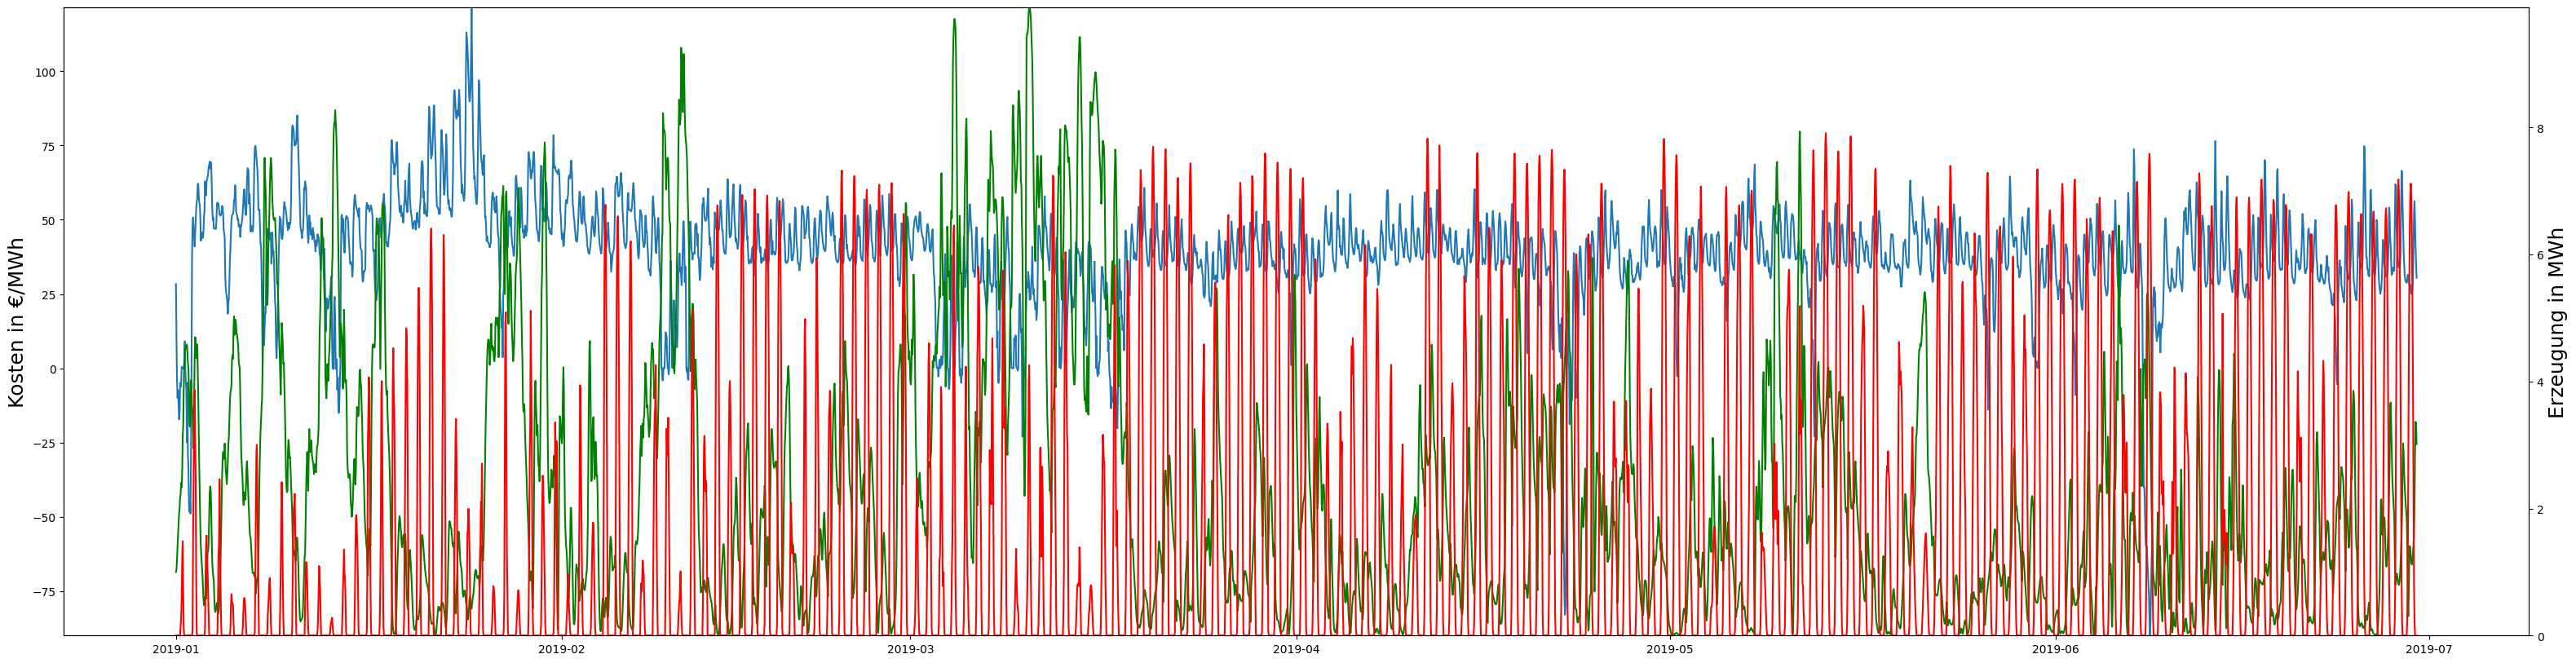

In [16]:
fig, ax1 = plt.subplots(figsize=(39,10))
ax2 = ax1.twinx()

ax1.plot(df_halbes_jahr["time"], df_halbes_jahr["Kosten"], label='Kosten')
ax2.plot(df_halbes_jahr["time"], df_halbes_jahr["wind"], color="g", label='Wind')
ax2.plot(df_halbes_jahr["time"], df_halbes_jahr["pv"], color="r", label='pv')
ax1.set_ylabel("Kosten in €/MWh", fontsize=18)
ax1.set_ylim([df_halbes_jahr.Kosten.min(),df_show.Kosten.max()])

ax2.set_ylabel("Erzeugung in MWh", fontsize=18)
ax2.set_ylim([0,df_halbes_jahr.wind.max()])


#ax1.legend(loc="upper left")
#ax2.legend(loc="upper center")
#ax3.legend(loc="upper right")

b) Profit ohne Speicher
-> heißt: wir besitzen 10 <br>
Annahme: Wir können mit unserer Anlage die maximal mögliche Erzeugung von 10 kV pro Anlage (Wind und PV) erzielen

In [17]:
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0


In [18]:
df['Preis in kWh/€'] = df.Kosten / 1000
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv,Preis in kWh/€
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0,0.02832
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0,0.01007
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0,-0.00408


In [19]:
df['Gewinn_Wind'] = df.wind * df['Preis in kWh/€']
df['Gewinn_PV'] = df.pv * df['Preis in kWh/€']
df['Gesamtgewinn'] = df['Gewinn_PV'] + df['Gewinn_Wind']
df.head(3)

,Datum,Uhrzeit,Kosten,time,wind,pv,Preis in kWh/€,Gewinn_Wind,Gewinn_PV,Gesamtgewinn
0,01.01.2019,00:00,28.32,2019-01-01 00:00:00,1.000,0.0,0.02832,0.028320,0.0,0.028320
1,01.01.2019,01:00,10.07,2019-01-01 01:00:00,1.038,0.0,0.01007,0.010453,0.0,0.010453
2,01.01.2019,02:00,-4.08,2019-01-01 02:00:00,1.184,0.0,-0.00408,-0.004831,-0.0,-0.004831


In [20]:
print('Der Gesamtgewinn für das Jahr 2019 beläuft sich auf:', round(df.Gesamtgewinn.sum()), '€')

Der Gesamtgewinn für das Jahr 2019 beläuft sich auf: 1021 €


# 1C) PV und Speicher

c) Profit mit Speicher
Zuerst Abspeichern der Daten, die für das Model benötigt werden als Liste.


In [21]:
#Variablen als Listen abspeichern
dap = df["Preis in kWh/€"].to_list()
pv = df["pv"].to_list()
wind = df["wind"].to_list()

#Länge festlegen
n_timesteps = len(df)

In [22]:
m  = Model("POP")  #Erstellt eine Instanz eines Gurobi-Gptimierungsmodells

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


In [23]:
# Zuerst müssen alle Entscheidungsvariablen definiert werden #t=1Stunde
pv_direkt = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=GRB.INFINITY, name = "pv_d") #was direkt verkauft wird, ub = Unendlich
pv_speicher = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "pv_s")#solar, das gespeichert wird ub = Leistung Speicher
speicher_raus = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "speicher_d") #Kapazität vom Speicher, max 5kw pro Stunde
speicher = m.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=15, name = "speicher") #Kapazität vom Speicher, max 5kw pro Stunde

#Zielfunktion
m.setObjective(( quicksum(dap[t] * (pv_direkt[t] + speicher_raus[t]) for t in range(n_timesteps) ) ), GRB.MAXIMIZE) #quicksum(... for t in range(start, end))  bildet die Summe über alle variablen von t=0 bis t=23

#Constraints
m.addConstrs((pv[t] == (pv_speicher[t] + pv_direkt[t]) for t in range(n_timesteps)), "Erzeugter Solarstrom für Zeitschritt t") 
m.addConstrs((speicher[t] == (speicher[t-1]+pv_speicher[t]-speicher_raus[t]) for t in range(1,n_timesteps-1)),"Speicher für Zeitschritt t") #Speicherlast zu Periode t

#Sonderfälle             
m.addConstr((speicher[0] ==  0 ) , "Sonderfall erster Zeitschritt")
m.addConstr((speicher[n_timesteps-1]== 0), "Sonderfall letzter Zeitschritt")             
             
m.optimize() # Hiermit sagen wir explizit, dass jetzt die optimierung des Modells "m" gestartet werden soll           


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17520 rows, 35040 columns and 52554 nonzeros
Model fingerprint: 0x4b32af65
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [5e+00, 2e+01]
  RHS range        [1e-03, 8e+00]
Presolve removed 12763 rows and 24798 columns
Presolve time: 0.04s
Presolved: 4757 rows, 10242 columns, 14998 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.756e+03
 Factor NZ  : 7.836e+04 (roughly 7 MB of memory)
 Factor Ops : 1.647e+06 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.08 seconds (0.04 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex ite

In [49]:
print("Gewinn Börse 2019 für Solar Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:")
m.getObjective().getValue()

Gewinn Börse 2019 für Solar Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:


525.4265623

In [101]:
def get_results_in_df(variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   

    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = m.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df                                               #Hier wird festgelegt, was zurückgegeben wird wenn die Funktion aufgerufen wird. In diesem Fall geben wir das fertige DataFrame mit den ergebnissen der Optimierung zurück

In [102]:

vn = ["pv_d", "pv_s", "speicher_d", "speicher" ] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
n = n_timesteps
test_results_pv = get_results_in_df(vn, n) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im 


In [103]:
test_results_pv

,pv_d,pv_s,speicher_d,speicher
0,0.0,0.0,5.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
8755,0.0,0.0,5.0,0.0
8756,0.0,0.0,0.0,0.0
8757,0.0,0.0,0.0,0.0
8758,0.0,0.0,0.0,0.0


###  Wind und Speicher
Selbes Model nun für Wind


In [38]:
p  = Model("WOP")  #Erstellt eine Instanz eines Gurobi-Gptimierungsmodells


In [39]:
# Zuerst müssen alle Entscheidungsvariablen definiert werden 

wind_direkt = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=GRB.INFINITY, name = "wind_d") #was direkt verkauft wird, ub = Unendlich
wind_speicher = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "wind_s")#wind, das gespeichert wird ub = Leistung Speicher
speicher_raus_w = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=5, name = "speicher_d_w") #Kapazität vom Speicher, max 5kw pro Stunde
speicher_w = p.addVars(range(n_timesteps), vtype = GRB.CONTINUOUS, lb = 0, ub=15, name = "speicher_w") #Kapazität vom Speicher, max 5kw pro Stunde

#Zielfunktion
p.setObjective((quicksum(dap[t] * (wind_direkt[t] + speicher_raus_w[t]) for t in range(n_timesteps) ) ), GRB.MAXIMIZE) #quicksum(... for t in range(start, end))  bildet die Summe über alle variablen von t=0 bis t=23


#Constraints
p.addConstrs((wind[t] == (wind_speicher[t] + wind_direkt[t]) for t in range(n_timesteps)), "Erzeugter Solarstrom für Periode t") 
p.addConstrs((speicher_w[t] == (speicher_w[t-1]+wind_speicher[t]-speicher_raus_w[t]) for t in range(1,n_timesteps-1)),"Speicher für Zeitschritt t") #Speicherlast zu Periode t

             
p.addConstr((speicher_w[0] ==  0 ) , "Sonderfall erster Zeitschritt")
p.addConstr((speicher_w[n_timesteps-1]== 0), "Sonderfall letzter Zeitschritt")             
             
p.optimize() # Hiermit sagen wir explizit, dass jetzt die optimierung des Modells "m" gestartet werden soll
           

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17520 rows, 35040 columns and 52554 nonzeros
Model fingerprint: 0x9f8f4f6d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [5e+00, 2e+01]
  RHS range        [8e-03, 1e+01]
Presolve removed 8762 rows and 17524 columns
Presolve time: 0.04s
Presolved: 8758 rows, 17516 columns, 26273 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.757e+03
 Factor NZ  : 1.445e+05 (roughly 12 MB of memory)
 Factor Ops : 3.038e+06 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.82677495e+02  1.39630842e+04  5.47e+

In [48]:
print("Gewinn Börse 2019 für Wind Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:")
p.getObjective().getValue()


Gewinn Börse 2019 für Wind Anlage von 10kw und Speicher mit Kapazität 15kwh und Leistung 5kw:


722.6436842799998

In [41]:
def get_results_in_df_w(variableNames, n_timesteps): #  "def name(argumente)" zeigt den Anfang einer Funktion an, die ich später beliebig aufrufen kann
   

    results_df = pd.DataFrame(columns = variableNames, index = [t for t in range(n_timesteps)] )   # Hier wird ein leeres DataFrame erstellt, dass als Spalteneinträge die Namen der Gutobi-variablen hat und als Zeilen die Zeitschritte der Entscheidungsvariablen

    for n in variableNames:                                         #Iteration über alle Zielvariablen
        for t in range(n_timesteps):                                #Iteration über alle Zeitschritte
            VarName = n + f"[{t}]"                                  #Hier wird ein String erstellt, der die Form n[t] hat. Mit diesem wird später die Zielvariable ausgelesen
            try:                                                    #try - except ist eine hilfreiche Methdoe, um Fehler abzufangen. Wenn in der nächsten Zeile ein error passiert, bspw. wegen eines Schreibfehlers in meinen zielvariablen, wird die Funktion nicht abgebrochen sondern weiter ausgeführt.
                results_df.loc[t][n] = p.getVarByName(VarName).x    #Auslesen der Zielvaribale
            except:
                pass
            
    return results_df

In [53]:
wn = ["wind_d", "wind_s", "speicher_d_w", "speicher_w" ] #Hier müssen die Namen meiner Gurobi-Zielvariablen stehen (siehe Optimeirung)
n = n_timesteps
test_results_wind = get_results_in_df_w(wn, n) # Aufrufen der Funktion und abspeichern meiner Ergebnisse im ''


In [104]:
#Dataframe mit alten Daten erweitern -> nur fürs plotten
test_results_wind['time']= df.time
test_results_wind['speicher_pv']= test_results_pv['speicher']

In [105]:
#Variablen als Numeric Abspeichern
test_results_wind['speicher_d_w']= pd.to_numeric(test_results_wind["speicher_d_w"])
test_results_wind['speicher_w']= pd.to_numeric(test_results_wind["speicher_w"])
test_results_wind['speicher_pv']= pd.to_numeric(test_results_wind["speicher_pv"])

In [106]:
test_results_wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wind_d        8760 non-null   object        
 1   wind_s        8760 non-null   object        
 2   speicher_d_w  8760 non-null   float64       
 3   speicher_w    8760 non-null   float64       
 4   time          8760 non-null   datetime64[ns]
 5   speicher_pv   8760 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 737.1+ KB


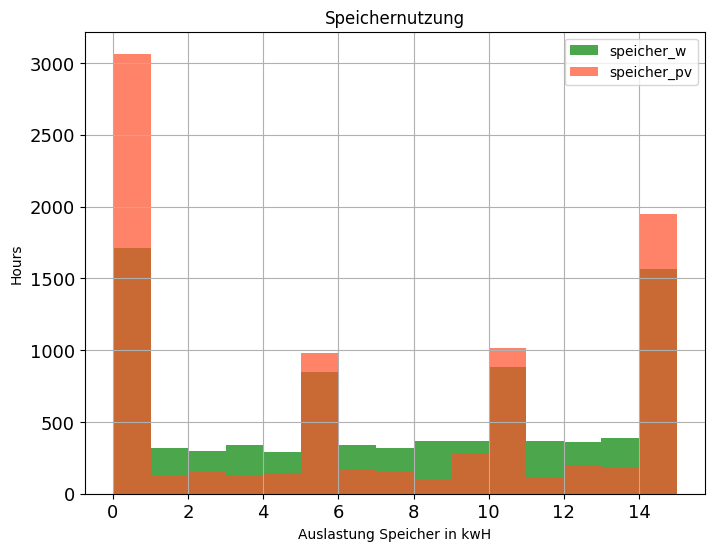

In [123]:
#Ein möglicher Plot, gibt garantiert bessere Darstellungsformen 

test_results_wind.plot(kind='hist',
        alpha=0.7,
        bins=15,
        column = ('speicher_w','speicher_pv'),
        title='Speichernutzung',
        #rot=45,
        grid=True,
        figsize=(8,6),
        fontsize=13, 
        color=['g','#FF4F29'])
plt.xlabel('Auslastung Speicher in kwH')
plt.ylabel("Hours"); 

d) 

Quelle für Sportmarkt-Preise: https://energy-charts.info/charts/price_spot_market/chart.htm?l=de&c=DE&year=2021&stacking=stacked_absolute_area&download-format=text%2Fcsv&interval=year